In [7]:
import math

import numpy as np
import sklearn.metrics
import torch
import torch.nn as nn
import torch.optim as optim
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (KBinsDiscretizer, MinMaxScaler,
                                   OneHotEncoder, StandardScaler, RobustScaler)
from torch.utils.data import DataLoader
from xgboost import plot_importance

from src.dataset import HousingDataset
from src.nn_model import MultipleRegression
from src.utils import (ColumnDropperTransformer, save_file,
                       ColumnNormalizedTransformer, get_data)

# Reading Data

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = get_data()

print(f"Length of the Train partition: {len(X_train)}")
print(f"Length of the Validation partition: {len(X_val)}")
print(f"Length of the Test partition: {len(X_test)}")

# Create Column Transformer with 2 types of transformers
numerical_features = X_train.select_dtypes(exclude="object").columns
categorical_features = X_train.select_dtypes(include="object").columns

Length of the Train partition: 12384
Length of the Validation partition: 4128
Length of the Test partition: 4128


## Preprocessing Pipeline

In [10]:
columns_to_remove = ["total_rooms", "total_bedrooms", "population"]

num_pipeline = Pipeline(
    steps=[
        ("normalizer", ColumnNormalizedTransformer()),
        ("columnDropper", ColumnDropperTransformer(columns=columns_to_remove)),
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler()),
    ]
)

cat_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("one_hot_encoder", OneHotEncoder()),
        ("scaler", StandardScaler(with_mean=False)),
    ]
)

preprocessor = ColumnTransformer(
    [
        ("num_pipeline", num_pipeline, numerical_features),
        ("cat_pipeline", cat_pipeline, categorical_features),
    ]
)

preprocessed_X_train = preprocessor.fit_transform(X_train)
preprocessed_X_val = preprocessor.transform(X_val)
preprocessed_X_test = preprocessor.transform(X_test)

print(f"Dataset has {X_train.shape[1]} number of features before preprocessing")
print(f"Dataset has {preprocessed_X_train.shape[1]} number of features after preprocessing")

Dataset has 9 number of features before preprocessing
Dataset has 13 number of features after preprocessing


In [17]:
new_num_cols = preprocessor.named_transformers_["num_pipeline"].named_steps["imputer"].get_feature_names_out()
new_cat_cols = preprocessor.named_transformers_["cat_pipeline"].named_steps["one_hot_encoder"].get_feature_names_out()
all_cols = np.concatenate([new_num_cols, new_cat_cols])

print("The complete set of feature names are as follows:")
print(all_cols)

The complete set of feature names are as follows:
['longitude' 'latitude' 'housing_median_age' 'households' 'median_income'
 'population_per_household' 'rooms_per_household' 'bedrooms_per_room'
 'x0_<1H OCEAN' 'x0_INLAND' 'x0_ISLAND' 'x0_NEAR BAY' 'x0_NEAR OCEAN']


#### Saving the Preprocesser

In [141]:
save_file(preprocessor, "preprocessor.joblib")

## Models

### 1) Linear Regression

In [5]:
regressor = LinearRegression()
regressor.fit(preprocessed_X_train,y_train)
predictions = regressor.predict(preprocessed_X_val)

mse = sklearn.metrics.mean_squared_error(y_val, predictions)  
rmse = math.sqrt(mse) 
print(f"RMSE: {rmse:.2f}, R2: {r2_score(y_val, predictions):.4}, MEA: {mean_absolute_error(y_val, predictions):.2f}")

RMSE: 70306.00, R2: 0.64, MEA: 51280.19


In [143]:
# Saving model
save_file(regressor, "regressor.joblib")

### 2) Random Forest

In [11]:
random_regressor = RandomForestRegressor()

random_regressor.fit(preprocessed_X_train, y_train)
predictions = random_regressor.predict(preprocessed_X_val)

mse = sklearn.metrics.mean_squared_error(y_val, predictions)  
rmse = math.sqrt(mse) 
print(f"RMSE: {rmse:.2f}, R2: {r2_score(y_val, predictions):.4}, MEA: {mean_absolute_error(y_val, predictions):.2f}")

RMSE: 50224.14, R2: 0.8163, MEA: 33108.09


In [146]:
# Saving model
save_file(random_regressor, "random_regressor.joblib")

### 3) XGBooost

In [12]:
xg_reg = xgb.XGBRegressor(
    objective='reg:linear',
    colsample_bytree=1,
    eta=0.3,
    learning_rate=0.1,
    max_depth=5,
    alpha=10,
    n_estimators=2000
)
xg_reg.fit(preprocessed_X_train, y_train)
predictions = xg_reg.predict(preprocessed_X_val)

mse = sklearn.metrics.mean_squared_error(y_val, predictions)  
rmse = math.sqrt(mse) 
print(f"RMSE: {rmse:.2f}, R2: {r2_score(y_val, predictions):.4}, MEA: {mean_absolute_error(y_val, predictions):.2f}")

[19:11:41] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 45856.44, R2: 0.8469, MEA: 29776.18


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

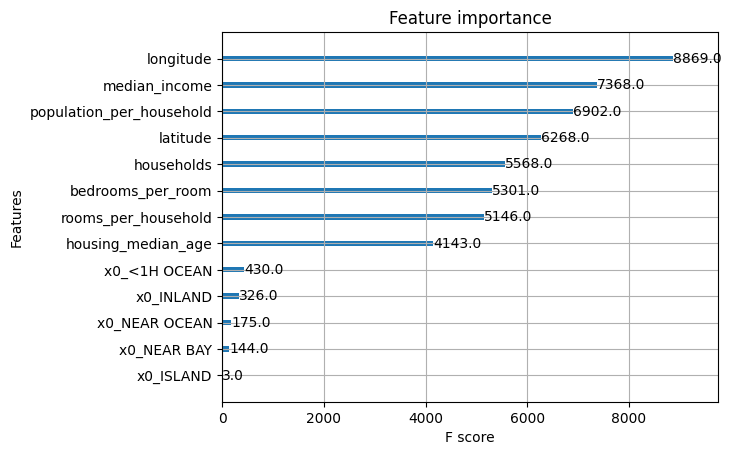

In [24]:
xg_reg.get_booster().feature_names = list(all_cols)
plot_importance(xg_reg)

### 4) Feed Forward Neural Network

#### Data Preperation

In [23]:
train_dataset = HousingDataset(torch.from_numpy(preprocessed_X_train).float(), torch.from_numpy(y_train.values).float())
val_dataset = HousingDataset(torch.from_numpy(preprocessed_X_val).float(), torch.from_numpy(y_val.values).float())
test_dataset = HousingDataset(torch.from_numpy(preprocessed_X_test).float(), torch.from_numpy(y_test.values).float())

n_epochs = 200   # number of epochs to run
batch_size = 100  # size of each batch

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=100)
test_loader = DataLoader(dataset=test_dataset, batch_size=100)

In [25]:
model = MultipleRegression(input_size=13, layers_config=(32,64,128,64,8), activation_function=nn.ReLU())
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.01)

# validation_step = 200
for epoch in range(n_epochs):    
    # running_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader, 0):
        # take a batch
        X_batch, y_batch = data
        # forward pass
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch.reshape(-1, 1))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        # print statistics
        # running_loss += math.sqrt(loss.item())
        # if i % validation_step == validation_step-1:    # print every 200 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / validation_step:.3f}')
        #     running_loss = 0.0
        #     print()

    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(preprocessed_X_val, dtype=torch.float32))
        mse = loss_fn(predictions, torch.tensor(y_val.values, dtype=torch.float32).reshape(-1, 1))
        print(f"Epoch {epoch+1}")
        print(f"R2: {r2_score(torch.tensor(y_val.values, dtype=torch.float32).reshape(-1, 1), predictions.detach().numpy()):.4}") 
        print(f"RMSE: {np.sqrt(mse.item()):.2f}")
        print()

Epoch 1
R2: -1.079
RMSE: 168973.79

Epoch 2
R2: 0.4201
RMSE: 89234.60

Epoch 3
R2: 0.3553
RMSE: 94090.06

Epoch 4
R2: 0.3557
RMSE: 94060.36

Epoch 5
R2: 0.5681
RMSE: 77013.19

Epoch 6
R2: 0.49
RMSE: 83683.41

Epoch 7
R2: 0.6941
RMSE: 64813.39

Epoch 8
R2: 0.6973
RMSE: 64468.84

Epoch 9
R2: 0.6996
RMSE: 64228.86

Epoch 10
R2: 0.702
RMSE: 63972.81

Epoch 11
R2: 0.7034
RMSE: 63816.08

Epoch 12
R2: 0.7039
RMSE: 63759.77

Epoch 13
R2: 0.7052
RMSE: 63626.32

Epoch 14
R2: 0.7064
RMSE: 63495.62

Epoch 15
R2: 0.7069
RMSE: 63437.74

Epoch 16
R2: 0.7077
RMSE: 63348.30

Epoch 17
R2: 0.708
RMSE: 63318.85

Epoch 18
R2: 0.7087
RMSE: 63248.59

Epoch 19
R2: 0.7092
RMSE: 63189.32

Epoch 20
R2: 0.7101
RMSE: 63096.55

Epoch 21
R2: 0.711
RMSE: 62991.06

Epoch 22
R2: 0.7123
RMSE: 62852.80

Epoch 23
R2: 0.7085
RMSE: 63267.76

Epoch 24
R2: 0.7148
RMSE: 62579.09

Epoch 25
R2: 0.7163
RMSE: 62417.90

Epoch 26
R2: 0.7179
RMSE: 62239.52

Epoch 27
R2: 0.7165
RMSE: 62389.73

Epoch 28
R2: 0.7209
RMSE: 61904.87

Epoch